In [128]:
# Notebook: Answers to Question 4
# Author: Ben Bernal
# Date: 29JUL2024

### Preliminaries

#### Libraries

In [129]:
import numpy as np
import pandas as pd
from os import path, listdir
from pprint import pprint
import re
import plotly.express as px
import plotly.graph_objects as go
from dataclasses import make_dataclass
from icecream import ic
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from random import gauss

#### Utilities

In [130]:
from utilities import json as util_json

#### Configuration

In [131]:
env_config = util_json.to_dict(
    file_path="../../config/env.json"
)

# Dataset

## Pre-processing

In [132]:
raw_frame = pd.read_csv(
    path.normpath(
        path.join(
            env_config['root'],
            "modules/m4/release_time_series_report_data_nops/CPI.csv"
        )
    )
)

print(raw_frame.head(3).to_markdown(tablefmt="grid"))

+----+-----------+-------+
|    | date      |   CPI |
+====+===========+=======+
|  0 | 7/24/2008 |   100 |
+----+-----------+-------+
|  1 | 7/25/2008 |   100 |
+----+-----------+-------+
|  2 | 7/26/2008 |   100 |
+----+-----------+-------+


In [133]:
frame = (
    raw_frame
    .assign(
        date_time_frmt = lambda X: pd.to_datetime(
                                        arg=X.date
                                    )
    )
    .set_index(
        keys='date_time_frmt',
        drop=False
    )    
    .assign(
        month = lambda X:  X.index.month
    )
    .dropna(
        subset=[
            'date',
            'CPI',
        ],
        how='any'
    )
)


print(frame.head(20).to_markdown(tablefmt="grid"))

+---------------------+-----------+---------+---------------------+---------+
| date_time_frmt      | date      |     CPI | date_time_frmt      |   month |
+=====================+===========+=========+=====================+=========+
| 2008-07-24 00:00:00 | 7/24/2008 | 100     | 2008-07-24 00:00:00 |       7 |
+---------------------+-----------+---------+---------------------+---------+
| 2008-07-25 00:00:00 | 7/25/2008 | 100     | 2008-07-25 00:00:00 |       7 |
+---------------------+-----------+---------+---------------------+---------+
| 2008-07-26 00:00:00 | 7/26/2008 | 100     | 2008-07-26 00:00:00 |       7 |
+---------------------+-----------+---------+---------------------+---------+
| 2008-07-27 00:00:00 | 7/27/2008 | 100     | 2008-07-27 00:00:00 |       7 |
+---------------------+-----------+---------+---------------------+---------+
| 2008-07-28 00:00:00 | 7/28/2008 | 100     | 2008-07-28 00:00:00 |       7 |
+---------------------+-----------+---------+-------------------

In [134]:
cpi_monthly_frame = (
    frame
    .resample(
        rule="MS",
        on = "date_time_frmt"
    )[
        'CPI'
    ]
    .agg(
        [
            'first'
        ]
    )
    .assign(
        month_idx = lambda X:  [i for i in range(X.shape[0])]
    )
)

print(
    cpi_monthly_frame.head().to_markdown(
        tablefmt='grid'
    )
    )

+---------------------+----------+-------------+
| date_time_frmt      |    first |   month_idx |
+=====================+==========+=============+
| 2008-07-01 00:00:00 | 100      |           0 |
+---------------------+----------+-------------+
| 2008-08-01 00:00:00 | 100.525  |           1 |
+---------------------+----------+-------------+
| 2008-09-01 00:00:00 | 100.124  |           2 |
+---------------------+----------+-------------+
| 2008-10-01 00:00:00 |  99.9854 |           3 |
+---------------------+----------+-------------+
| 2008-11-01 00:00:00 |  98.9754 |           4 |
+---------------------+----------+-------------+


## Train Test Split

In [135]:
train_frame = frame.loc[:'2013-08-31']

print(
    train_frame.tail().to_markdown(tablefmt='grid')
)

+---------------------+-----------+---------+---------------------+---------+
| date_time_frmt      | date      |     CPI | date_time_frmt      |   month |
+=====================+===========+=========+=====================+=========+
| 2013-08-27 00:00:00 | 8/27/2013 | 106.755 | 2013-08-27 00:00:00 |       8 |
+---------------------+-----------+---------+---------------------+---------+
| 2013-08-28 00:00:00 | 8/28/2013 | 106.755 | 2013-08-28 00:00:00 |       8 |
+---------------------+-----------+---------+---------------------+---------+
| 2013-08-29 00:00:00 | 8/29/2013 | 106.755 | 2013-08-29 00:00:00 |       8 |
+---------------------+-----------+---------+---------------------+---------+
| 2013-08-30 00:00:00 | 8/30/2013 | 106.755 | 2013-08-30 00:00:00 |       8 |
+---------------------+-----------+---------+---------------------+---------+
| 2013-08-31 00:00:00 | 8/31/2013 | 106.755 | 2013-08-31 00:00:00 |       8 |
+---------------------+-----------+---------+-------------------

In [136]:
test_frame = frame.loc['2013-09-01':]

print(
    test_frame.head().to_markdown(tablefmt='grid')
)

+---------------------+----------+---------+---------------------+---------+
| date_time_frmt      | date     |     CPI | date_time_frmt      |   month |
+=====================+==========+=========+=====================+=========+
| 2013-09-01 00:00:00 | 9/1/2013 | 106.883 | 2013-09-01 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+
| 2013-09-02 00:00:00 | 9/2/2013 | 106.883 | 2013-09-02 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+
| 2013-09-03 00:00:00 | 9/3/2013 | 106.883 | 2013-09-03 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+
| 2013-09-04 00:00:00 | 9/4/2013 | 106.883 | 2013-09-04 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+
| 2013-09-05 00:00:00 | 9/5/2013 | 106.883 | 2013-09-05 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+

# Manipulations

## Trend

In [137]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['first'],
        name='Monthly CPI Trend',
        mode="markers+lines"
    )
)
fig.show()

## Linear Projection

In [138]:
reg = LinearRegression().fit(
    X = cpi_monthly_frame.loc[:"2013-08-31"][['month_idx']],
    y=cpi_monthly_frame.loc[:"2013-08-31"][['first']]
)

In [139]:
cpi_monthly_frame['cpi_linear_model'] = None
cpi_monthly_frame.loc[:"2013-08-31", 'cpi_linear_model'] = reg.predict(
    X=cpi_monthly_frame.loc[:"2013-08-31"][['month_idx']]
)
cpi_monthly_frame.loc["2013-09-01":,'cpi_linear_model'] = reg.predict(
    X=cpi_monthly_frame.loc["2013-09-01":][['month_idx']]
)

In [140]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['first'],
        name='Monthly CPI Trend',
        mode="markers+lines"
    )
)
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['cpi_linear_model'],
        name='CPI Linear Model',
        mode="markers+lines"
    )
)
fig.show()

In [141]:
ic(reg.coef_)
ic(reg.intercept_)

ic| reg.coef_: array([[0.16104348]])


ic| reg.intercept_: array([96.72932633])


array([96.72932633])

In [142]:
reg.intercept_[0] + (reg.coef_[0] * 62)

array([106.71402232])

In [143]:
cpi_monthly_frame['residuals_linear_model'] = cpi_monthly_frame['first'] - cpi_monthly_frame['cpi_linear_model']

In [144]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['residuals_linear_model'],
        name='Residuals',
        mode="markers"
    )
)

fig.show()

In [145]:
max(cpi_monthly_frame.loc[:'2013-08-31','residuals_linear_model'])

3.634730187605456

## Auto Correlation

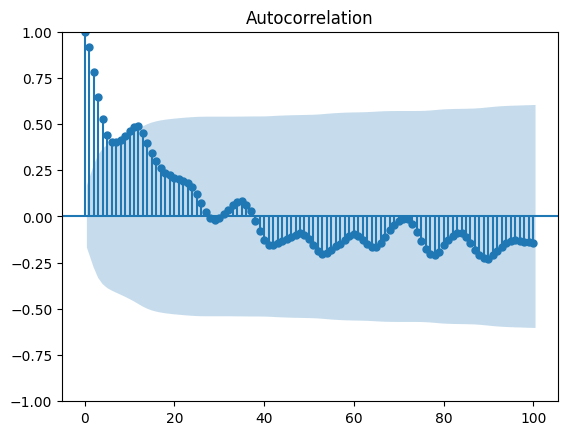

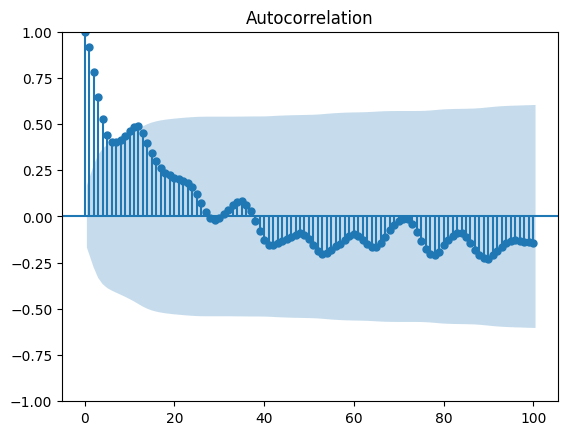

In [146]:
plot_acf(
    x = cpi_monthly_frame[
        [
            'residuals_linear_model'
        ]
    ],
    lags = 100
)

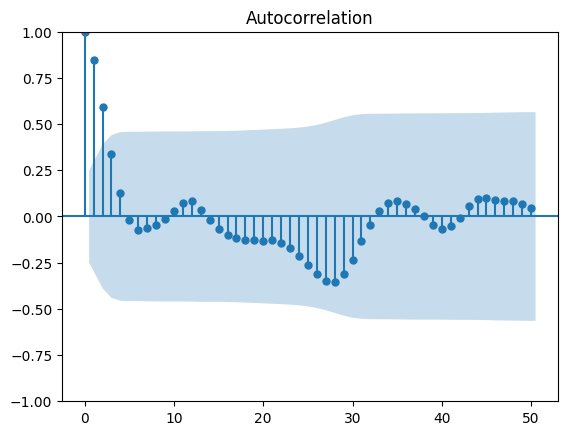

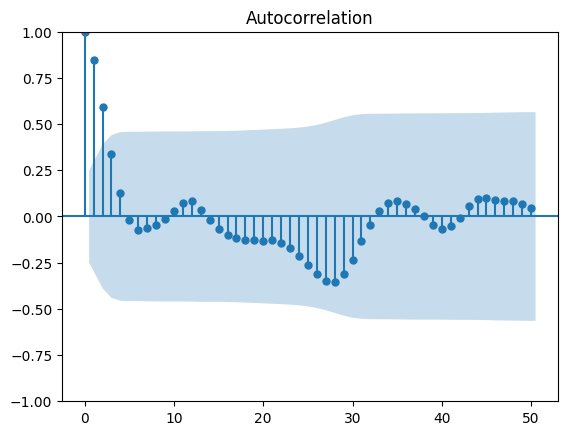

In [147]:
plot_acf(
    x = cpi_monthly_frame[['residuals_linear_model']].loc[:'2013-08-31'],
    lags = 50
)

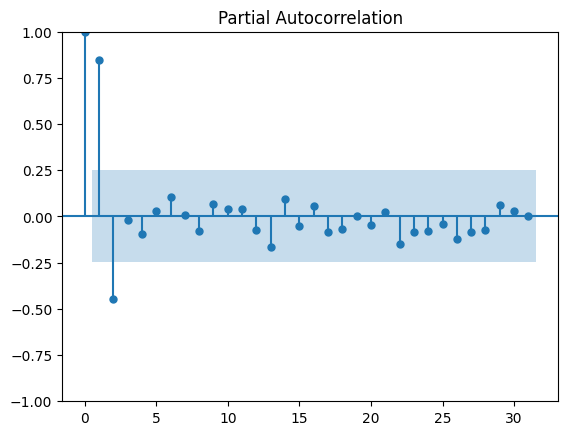

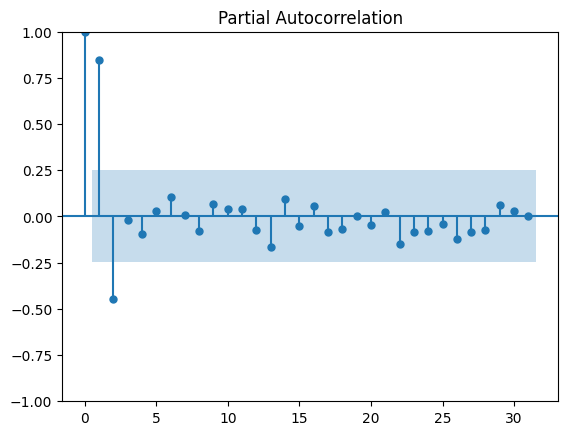

In [148]:
plot_pacf(
    x = cpi_monthly_frame[['residuals_linear_model']].loc[:'2013-08-31'],
    lags = 31
    
)

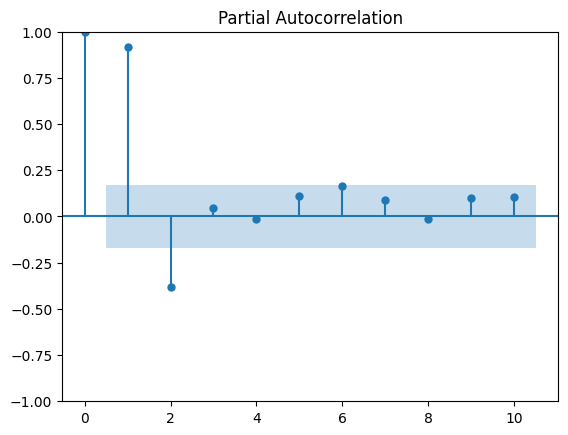

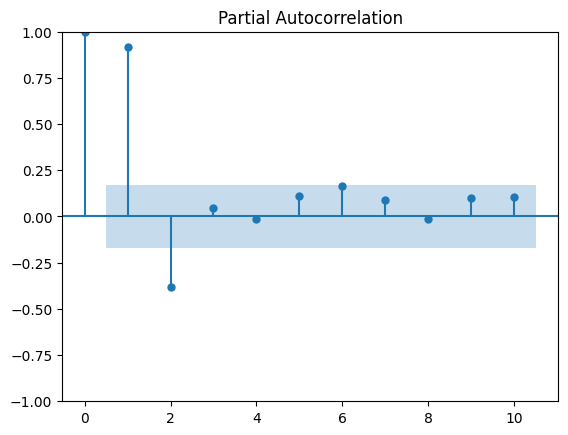

In [149]:
plot_pacf(
    x = cpi_monthly_frame[['residuals_linear_model']],
    lags = 10
    
)

## AR Model

In [150]:
# ar = AutoReg(
#     endog=cpi_monthly_frame['first'].loc[:'2013-08-31'],
#     lags=2,
#     trend='t'
# ).fit()

In [151]:
# ic(ar.ar_lags)
# ic(ar.params)
# ic(ar.roots)

In [152]:
ic(cpi_monthly_frame.shape)
ic(cpi_monthly_frame.dropna(subset=['residuals_linear_model']).shape)

ic| cpi_monthly_frame.shape: (136, 4)
ic| cpi_monthly_frame.dropna(subset=['residuals_linear_model']).shape: (136, 4)


(136, 4)

In [153]:
cpi_monthly_frame['residuals_linear_model'] = cpi_monthly_frame['residuals_linear_model'].astype('float')

In [154]:
ar = AutoReg(
    endog=cpi_monthly_frame['residuals_linear_model'].loc[:'2013-08-31'],
    lags=2,
    trend='n'
).fit()

In [155]:
ic(ar.ar_lags)
ic(ar.params)
ic(ar.roots)

ic| ar.ar_lags: [1, 2]
ic| ar.params: residuals_linear_model.L1    1.335546
               residuals_linear_model.L2   -0.540567
               dtype: float64
ic| ar.roots: array([1.23531901-0.56911834j, 1.23531901+0.56911834j])


array([1.23531901-0.56911834j, 1.23531901+0.56911834j])

In [156]:
gauss(mu = 0, sigma=ar.sigma2)

-0.029669336660127804

In [157]:
(ar.params.iloc[0] * 0.20212) + (ar.params.iloc[1]*0.321 )

0.09641846249878405

In [158]:
(ar.params.iloc[0] * 0.1695) + (ar.params.iloc[1]*0.2012 )

0.11761290705814632

In [159]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                               
==================================================================================
Dep. Variable:     residuals_linear_model   No. Observations:                   62
Model:                         AutoReg(2)   Log Likelihood                 -17.989
Method:                   Conditional MLE   S.D. of innovations              0.327
Date:                    Mon, 05 Aug 2024   AIC                             41.979
Time:                            18:38:02   BIC                             48.262
Sample:                        09-01-2008   HQIC                            44.436
                             - 08-01-2013                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
residuals_linear_model.L1     1.3355      0.099     13.559      0.000       1.142       1.529
residuals_linear_model.L2    -0.5406      0.091     -5.913      0.000      -0.720      -0.361
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2353           -0.5691j            1.3601           -0.0687
AR.2            1.2353           +0.5691j            1.3601            0.0687
-----------------------------------------------------------------------------
"""

In [160]:
ic(ar.sigma2)

ic| ar.sigma2: 0.10664716499619763


0.10664716499619763

## Forecasting

In [161]:
cpi_monthly_frame

,first,month_idx,cpi_linear_model,residuals_linear_model
date_time_frmt,,,,
2008-07-01,100.00000,0,96.729326,3.270674
2008-08-01,100.52510,1,96.89037,3.634730
2008-09-01,100.12380,2,97.051413,3.072387
2008-10-01,99.98538,3,97.212457,2.772923
2008-11-01,98.97539,4,97.3735,1.601890
...,...,...,...,...
2019-06-01,117.03590,131,117.826023,-0.790123
2019-07-01,117.05920,132,117.987066,-0.927866
2019-08-01,117.25480,133,118.14811,-0.893310


In [162]:
cpi_monthly_frame['ar_model'] = np.nan
cpi_monthly_frame.loc['2013-09-01':, 'ar_model'] = ar.predict(
    start='2013-09-01',
    end = '2019-10-01'
)


In [163]:
cpi_monthly_frame['cpi_naive_forecast'] = cpi_monthly_frame['cpi_linear_model'] + cpi_monthly_frame['ar_model']

In [164]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['first'],
        name='Monthly CPI Trend',
        mode="markers+lines"
    )
)
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['cpi_naive_forecast'],
        name='Naive Forecast',
        mode="markers+lines"
    )
)
fig.show()

In [165]:
ic(
    rmse(
        y_true=cpi_monthly_frame['first'].loc['2013-09-01':],
        y_pred=cpi_monthly_frame['cpi_naive_forecast'].loc['2013-09-01':]
    )
)

ic| rmse(
        y_true=cpi_monthly_frame['first'].loc['2013-09-01':],
        y_pred=cpi_monthly_frame['cpi_naive_forecast'].loc['2013-09-01':]
    ): 1.7998375178536412


1.7998375178536412

In [166]:
ar.forecast(
    steps='2013-09-01'
)

2013-09-01    0.096385
Freq: MS, dtype: float64

In [167]:
ar.predict(
    start='2013-01-01',
    end = '2013-12-01'
)

2013-01-01   -0.399188
2013-02-01   -0.634805
2013-03-01   -0.195268
2013-04-01    0.660075
2013-05-01    0.436614
2013-06-01    0.010923
2013-07-01    0.195369
2013-08-01    0.306300
2013-09-01    0.096385
2013-10-01    0.019467
2013-11-01   -0.026104
2013-12-01   -0.045386
Freq: MS, dtype: float64

In [168]:
(ar.params.iloc[0] *  0.202121) + (ar.params.iloc[1]*0.321065)

0.09638466117603683

In [169]:
cpi_monthly_frame['2013-01-01':'2013-12-01']

,first,month_idx,cpi_linear_model,residuals_linear_model,ar_model,cpi_naive_forecast
date_time_frmt,,,,,,
2013-01-01,104.9293,54,105.425674,-0.496374,NaN,NaN
2013-02-01,105.2396,55,105.586718,-0.347118,NaN,NaN
2013-03-01,106.1015,56,105.747761,0.353739,NaN,NaN
2013-04-01,106.3789,57,105.908805,0.470095,NaN,NaN
2013-05-01,106.2683,58,106.069848,0.198452,NaN,NaN
2013-06-01,106.4575,59,106.230892,0.226608,NaN,NaN
2013-07-01,106.7130,60,106.391935,0.321065,NaN,NaN
2013-08-01,106.7551,61,106.552979,0.202121,NaN,NaN
2013-09-01,106.8835,62,106.714022,0.169478,0.096385,106.810407


In [170]:
forecast_cpi_dict = {}

forecast_residuals_dict = {}

r_t_1 = cpi_monthly_frame.loc['2013-08-01', 'residuals_linear_model']

r_t_2 = cpi_monthly_frame.loc['2013-07-01', 'residuals_linear_model']

for tpl_row in cpi_monthly_frame.loc['2013-09-01':].itertuples():
    
    ic(tpl_row)
    ic(tpl_row.Index)
    r_t = (ar.params.iloc[0] * r_t_1) + (ar.params.iloc[1] * r_t_2)
    forecast_residuals_dict[tpl_row.Index] = r_t
    ic(r_t)
    ic(tpl_row.cpi_linear_model)
    cpi_forecast = tpl_row.cpi_linear_model + r_t
    ic(cpi_forecast)
    forecast_cpi_dict[tpl_row.Index] = cpi_forecast
    r_t_2 = r_t_1
    ic(r_t_2)
    r_t_1 = tpl_row.residuals_linear_model;
    ic(r_t_1)

    # break

ic| tpl_row: Pandas(Index=Timestamp('2013-09-01 00:00:00'), first=106.8835, month_idx=62, cpi_linear_model=106.71402231623478, residuals_linear_model=0.16947768376522276, ar_model=0.096385073394407, cpi_naive_forecast=106.81040738962918)
ic| tpl_row.Index: Timestamp('2013-09-01 00:00:00')
ic| r_t: 0.096385073394407
ic| tpl_row.cpi_linear_model: 106.71402231623478
ic| cpi_forecast: 106.81040738962918
ic| r_t_2: 0.20212116743472563
ic| r_t_1: 0.16947768376522276
ic| tpl_row: Pandas(Index=Timestamp('2013-10-01 00:00:00'), first=107.0078, month_idx=63, cpi_linear_model=106.87506579990429, residuals_linear_model=0.13273420009571169, ar_model=0.01946661384424743, cpi_naive_forecast=106.89453241374854)
ic| tpl_row.Index: Timestamp('2013-10-01 00:00:00')
ic| r_t: 0.11708514979226899
ic| tpl_row.cpi_linear_model: 106.87506579990429
ic| cpi_forecast: 106.99215094969657
ic| r_t_2: 0.16947768376522276
ic| r_t_1: 0.13273420009571169
ic| tpl_row: Pandas(Index=Timestamp('2013-11-01 00:00:00'), first=

In [171]:
cpi_monthly_frame = (
    cpi_monthly_frame
    .assign(
        cpi_forecast = lambda X: X.index.map(
            lambda y: forecast_cpi_dict.get(y)
        ),
        iterative_residuals = lambda X: X.index.map(
            lambda y: forecast_residuals_dict.get(y)
        )
    )
)

In [172]:
cpi_monthly_frame

,first,month_idx,cpi_linear_model,residuals_linear_model,ar_model,cpi_naive_forecast,cpi_forecast,iterative_residuals
date_time_frmt,,,,,,,,
2008-07-01,100.00000,0,96.729326,3.270674,NaN,NaN,NaN,NaN
2008-08-01,100.52510,1,96.89037,3.634730,NaN,NaN,NaN,NaN
2008-09-01,100.12380,2,97.051413,3.072387,NaN,NaN,NaN,NaN
2008-10-01,99.98538,3,97.212457,2.772923,NaN,NaN,NaN,NaN
2008-11-01,98.97539,4,97.3735,1.601890,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-06-01,117.03590,131,117.826023,-0.790123,8.516987e-11,117.826023,117.373789,-0.452234
2019-07-01,117.05920,132,117.987066,-0.927866,7.638613e-11,117.987066,117.406266,-0.580801
2019-08-01,117.25480,133,118.14811,-0.893310,5.597715e-11,118.14811,117.336016,-0.812093


In [173]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['first'],
        name='Monthly CPI Trend',
        mode="markers+lines"
    )
)
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['cpi_forecast'],
        name='AR Forecast',
        mode="markers+lines"
    )
)
fig.show()

In [174]:
ic(
    rmse(
        y_true=cpi_monthly_frame['first'].loc['2013-09-01':],
        y_pred=cpi_monthly_frame['cpi_forecast'].loc['2013-09-01':]
    )
)

ic| rmse(
        y_true=cpi_monthly_frame['first'].loc['2013-09-01':],
        y_pred=cpi_monthly_frame['cpi_forecast'].loc['2013-09-01':]
    ): 0.41950097457801905


0.41950097457801905

## Monthly Inflation Rate

In [175]:
cpi_monthly_frame = (
    cpi_monthly_frame
    .rename(
        columns={
            'first' : 'cpi'
        }
    )
    .assign(
        cpi_lag = lambda X: X.cpi.shift(
            periods = 1
        )
    )
    .assign(
        inflation_rate = lambda X: X.apply(
            lambda y: ((y.cpi - y.cpi_lag)/y.cpi_lag),
            axis =1
        ),
        inflation_rate_ln = lambda X: X.apply(
            lambda y: (np.log(y.cpi) - np.log(y.cpi_lag)),
            axis =1
        ),
    )
    .assign(
        inflation_rate_percent = lambda X: X.inflation_rate * 100
    )
)

In [176]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['inflation_rate_percent'],
        name='Inflation Rate Fraction',
        mode="markers+lines"
    )
)

fig.update_layout(legend=dict(
    orientation="h",
    # entrywidth=70,
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=0.95
))
fig.update_layout(
    title_text = "Monthly Inflation Rate = {[CPI(t) - CPI(t-1)]/CPI(t-1)} * 100",
    yaxis_title_text = '[%]'
)
fig.show()

### Centering

In [177]:
def centering(x):
    assert x.shape[0] == 13, "Not the right ammount of values"
    # if x.shape[0] != 13:
    #     print('here')
    x.iloc[0] = x.iloc[0] * 0.5
    x.iloc[-1] = x.iloc[-1] * 0.5
    return (x.sum()/12)

In [178]:
(
    cpi_monthly_frame
    .dropna(
        subset=[
            'inflation_rate_percent'
        ]
    )
    .assign(
        centered_moving_average = lambda X: X['inflation_rate_percent'].rolling(
            window = 13,
            min_periods=13,
            center=True,
            closed = 'neither'
        ).apply(
            func = centering,
            raw = False
        )
    )
)

,cpi,month_idx,cpi_linear_model,residuals_linear_model,ar_model,cpi_naive_forecast,cpi_forecast,iterative_residuals,cpi_lag,inflation_rate,inflation_rate_ln,inflation_rate_percent,centered_moving_average
date_time_frmt,,,,,,,,,,,,,
2008-08-01,100.52510,1,96.89037,3.634730,NaN,NaN,NaN,NaN,100.00000,0.005251,0.005237,0.525100,NaN
2008-09-01,100.12380,2,97.051413,3.072387,NaN,NaN,NaN,NaN,100.52510,-0.003992,-0.004000,-0.399204,NaN
2008-10-01,99.98538,3,97.212457,2.772923,NaN,NaN,NaN,NaN,100.12380,-0.001382,-0.001383,-0.138249,NaN
2008-11-01,98.97539,4,97.3735,1.601890,NaN,NaN,NaN,NaN,99.98538,-0.010101,-0.010153,-1.010138,NaN
2008-12-01,97.07973,5,97.534544,-0.454814,NaN,NaN,NaN,NaN,98.97539,-0.019153,-0.019339,-1.915284,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01,117.03590,131,117.826023,-0.790123,8.516987e-11,117.826023,117.373789,-0.452234,116.78730,0.002129,0.002126,0.212866,NaN
2019-07-01,117.05920,132,117.987066,-0.927866,7.638613e-11,117.987066,117.406266,-0.580801,117.03590,0.000199,0.000199,0.019908,NaN
2019-08-01,117.25480,133,118.14811,-0.893310,5.597715e-11,118.14811,117.336016,-0.812093,117.05920,0.001671,0.001670,0.167095,NaN


In [179]:
centering(
    x=cpi_monthly_frame.inflation_rate_percent.loc['2008-08-01':'2009-08-01']
)

-0.14505417981019

In [181]:
cpi_monthly_frame.inflation_rate_percent.rolling(
            window = 13,
            min_periods=13,
            center=True,
            closed = 'neither'
        ).apply(
            centering,
            raw = False,
        )

date_time_frmt
2008-07-01   NaN
2008-08-01   NaN
2008-09-01   NaN
2008-10-01   NaN
2008-11-01   NaN
              ..
2019-06-01   NaN
2019-07-01   NaN
2019-08-01   NaN
2019-09-01   NaN
2019-10-01   NaN
Freq: MS, Name: inflation_rate_percent, Length: 136, dtype: float64

In [125]:
type(cpi_monthly_frame.inflation_rate_percent)

pandas.core.series.Series